<a href="https://colab.research.google.com/github/ananthomprakash/NLP--Huffington-Post-News-Category-Analysis/blob/master/NLP_News_Category_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics:

*   Language Detection

*   Text Cleaning

*   Measures of Length
*   Sentiment Analysis


*   Named-Entity Recognition


*   N-Grams Frequency

*   Word Vectors
*   Topic Modelling








Here we are using New Category DataSet to classify the topics with right category

1) Importing necessary libraries

In [4]:
## for data
import pandas as pd
import collections
import json
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
## for text processing
import re
import nltk

## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
pip install langdetect

In [6]:
## for language detection
import langdetect 

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one      
lst_dics[0]

{'authors': 'Melissa Jeltsen',
 'category': 'CRIME',
 'date': '2018-05-26',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.'}

The original dataset contains over 30 categories, but for now, I will work with a subset of 3: Entertainment, Politics, and Tech.

In [9]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,y,text
7692,POLITICS,Trump Supporters Have Lots Of Excuses For His ...
21414,POLITICS,'Because... Climate Change'
75264,POLITICS,"We’re Still, Somehow, A Year Away From The Pre..."
78276,ENTERTAINMENT,Rooney Mara Says She 'Felt Really Bad' About '...
25500,POLITICS,Trump's Tweets Might Be Lawyered. But Who Will...


In [10]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       50879 non-null  object
 1   text    50879 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


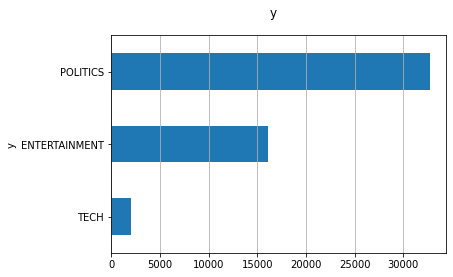

In [11]:
x = "y"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
dtf[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The dataset is imbalanced: the proportion of Tech news is really small compared to the others. This can be an issue during modeling and a resample of the dataset may be useful.

In [12]:
dtf.shape

(50879, 2)

In [13]:
dtf["y"].value_counts()

POLITICS         32739
ENTERTAINMENT    16058
TECH              2082
Name: y, dtype: int64

In [14]:
POLITICS=dtf[dtf["y"]=='POLITICS']
ENTERTAINMENT=dtf[dtf["y"]=='ENTERTAINMENT']
TECH=dtf[dtf["y"]=='TECH']

In [15]:
print(POLITICS.shape)
print(TECH.shape)
print(ENTERTAINMENT.shape)

(32739, 2)
(2082, 2)
(16058, 2)


In [16]:
POLITICS=POLITICS.sample(TECH.shape[0])
ENTERTAINMENT=ENTERTAINMENT.sample(TECH.shape[0])

In [17]:
POLITICS=POLITICS.append(ENTERTAINMENT,ignore_index=True)

In [18]:
dtf=POLITICS.append(TECH,ignore_index=True)

In [19]:
dtf.shape

(6246, 2)

In [20]:
dtf.head()

,y,text
0,POLITICS,Department Of Education Gives States Guidance ...
1,POLITICS,Watch Obama Deliver His Farewell Address
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W..."
3,POLITICS,Populism Was The Real Winner On Tuesday Night
4,POLITICS,The Party Still Decides


In [21]:
dtf["y"].value_counts()

ENTERTAINMENT    2082
POLITICS         2082
TECH             2082
Name: y, dtype: int64

In [22]:
dtf['lang'] = dtf["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")
dtf.head()

,y,text,lang
0,POLITICS,Department Of Education Gives States Guidance ...,en
1,POLITICS,Watch Obama Deliver His Farewell Address,de
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en
4,POLITICS,The Party Still Decides,en


In [23]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Text Pre Processing

In [26]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [27]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
dtf["text_clean"] = dtf["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [29]:
dtf.head()

,y,text,lang,text_clean
0,POLITICS,Department Of Education Gives States Guidance ...,en,department education give state guidance new s...
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en,obama stood party outsider work strengthen dem...
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en,populism real winner tuesday night
4,POLITICS,The Party Still Decides,en,party still decides
5,POLITICS,Only One Juror Stands Between Michael Slager A...,en,one juror stand michael slager conviction walt...


Length Analysis

There are several length measures for text data:

word count: counts the number of tokens in the text (separated by a space)

character count: sum the number of characters of each token

sentence count: count the number of sentences (separated by a period)

average word length: sum of words length divided by the number of words (character count/word count)

average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)


In [30]:
dtf['word_count'] = dtf["text"].apply(lambda x: len(str(x).split(" ")))
dtf['char_count'] = dtf["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
dtf['sentence_count'] = dtf["text"].apply(lambda x: len(str(x).split(".")))
dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
dtf.head()

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,POLITICS,Department Of Education Gives States Guidance ...,en,department education give state guidance new s...,10,55,1,5.500000,10.0
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en,obama stood party outsider work strengthen dem...,12,63,1,5.250000,12.0
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en,populism real winner tuesday night,8,38,1,4.750000,8.0
4,POLITICS,The Party Still Decides,en,party still decides,4,20,1,5.000000,4.0
5,POLITICS,Only One Juror Stands Between Michael Slager A...,en,one juror stand michael slager conviction walt...,14,73,1,5.214286,14.0


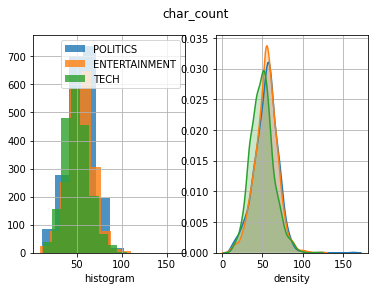

In [31]:
x, y = "char_count", "y"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in dtf[y].unique():
    sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(dtf[y].unique())
ax[1].grid(True)
plt.show()

Sentiment Analysis

In [32]:
dtf["sentiment"] = dtf["text_clean"].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)
dtf.head()

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,POLITICS,Department Of Education Gives States Guidance ...,en,department education give state guidance new s...,10,55,1,5.500000,10.0,0.136364
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en,obama stood party outsider work strengthen dem...,12,63,1,5.250000,12.0,0.000000
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en,populism real winner tuesday night,8,38,1,4.750000,8.0,0.200000
4,POLITICS,The Party Still Decides,en,party still decides,4,20,1,5.000000,4.0,0.000000
5,POLITICS,Only One Juror Stands Between Michael Slager A...,en,one juror stand michael slager conviction walt...,14,73,1,5.214286,14.0,0.000000


Named-Entity Recognition

NER (Named-entity recognition) is the process to tag named entities mentioned in unstructured text with pre-defined categories such as person names, organizations, locations, time expressions, quantities, etc.

In [33]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [34]:
## call model
import spacy
ner = spacy.load('en_core_web_lg')

In [35]:

## tag text
txt = dtf["text"].iloc[0]
doc = ner(txt)
## display result
spacy.displacy.render(doc, style="ent")

'<div class="entities" style="line-height: 2.5; direction: ltr">\n<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">\n    Department Of Education Gives States Guidance On New Schools Law\n    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>\n</mark>\n</div>'

In [36]:
## tag text and exctract tags into a list
dtf["tags"] = dtf["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in ner(x).ents] )
## utils function to count the element of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count

## count tags
dtf["tags"] = dtf["tags"].apply(lambda x: utils_lst_count(x))

## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0

## extract features
tags_set = []
for lst in dtf["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     dtf["tags_"+feature] = dtf["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))

## print result
dtf.head()

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags,tags_MONEY,tags_LOC,tags_ORDINAL,tags_WORK_OF_ART,tags_ORG,tags_LAW,tags_GPE,tags_CARDINAL,tags_PERCENT,tags_PRODUCT,tags_FAC,tags_TIME,tags_QUANTITY,tags_DATE,tags_NORP,tags_EVENT,tags_PERSON
0,POLITICS,Department Of Education Gives States Guidance ...,en,department education give state guidance new s...,10,55,1,5.500000,10.0,0.136364,[{('Department Of Education Gives States Guida...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en,obama stood party outsider work strengthen dem...,12,63,1,5.250000,12.0,0.000000,"[{('Obama', 'ORG'): 1}, {('Democrats', 'NORP')...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en,populism real winner tuesday night,8,38,1,4.750000,8.0,0.200000,"[{('Tuesday Night', 'TIME'): 1}]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,POLITICS,The Party Still Decides,en,party still decides,4,20,1,5.000000,4.0,0.000000,"[{('Party', 'ORG'): 1}]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,POLITICS,Only One Juror Stands Between Michael Slager A...,en,one juror stand michael slager conviction walt...,14,73,1,5.214286,14.0,0.000000,"[{('Only One', 'CARDINAL'): 1}, {('Michael Sla...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


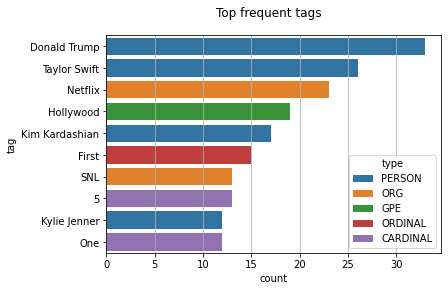

In [45]:
y = "ENTERTAINMENT"
top=10
tags_list = dtf[dtf["y"]==y]["tags"].sum()
map_lst = list(map(lambda x: list(x.keys())[0], tags_list))
dtf_tags = pd.DataFrame(map_lst, columns=['tag','type'])
dtf_tags["count"] = 1
dtf_tags = dtf_tags.groupby(['type',  
                'tag']).count().reset_index().sort_values("count", 
                 ascending=False)
fig, ax = plt.subplots()
fig.suptitle("Top frequent tags", fontsize=12)
sns.barplot(x="count", y="tag", hue="type", 
            data=dtf_tags.iloc[:top,:], dodge=False, ax=ax)
ax.grid(axis="x")
plt.show()

In [46]:
## predict wit NER
txt = dtf["text"].iloc[0]
entities = ner(txt).ents
## tag text
tagged_txt = txt
for tag in entities:
    tagged_txt = re.sub(tag.text, "_".join(tag.text.split()), 
                        tagged_txt) 
## show result
print(tagged_txt)

Department_Of_Education_Gives_States_Guidance_On_New_Schools_Law


In [47]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

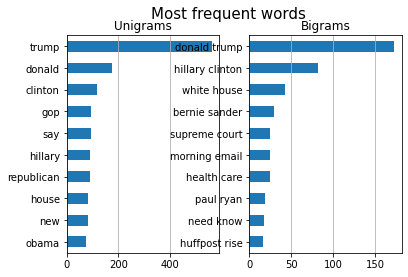

In [48]:
y = "POLITICS"
corpus = dtf[dtf["y"]==y]["text_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
    
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [49]:
lst_words = ["box office", "republican", "apple"]
## count
lst_grams = [len(word.split(" ")) for word in lst_words]
vectorizer = feature_extraction.text.CountVectorizer(
                 vocabulary=lst_words, 
                 ngram_range=(min(lst_grams),max(lst_grams)))
dtf_X = pd.DataFrame(vectorizer.fit_transform(dtf["text_clean"]).todense(), columns=lst_words)
## add the new features as columns
dtf = pd.concat([dtf, dtf_X.set_index(dtf.index)], axis=1)
dtf.head()

,y,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags,tags_MONEY,tags_LOC,tags_ORDINAL,tags_WORK_OF_ART,tags_ORG,tags_LAW,tags_GPE,tags_CARDINAL,tags_PERCENT,tags_PRODUCT,tags_FAC,tags_TIME,tags_QUANTITY,tags_DATE,tags_NORP,tags_EVENT,tags_PERSON,box office,republican,apple
0,POLITICS,Department Of Education Gives States Guidance ...,en,department education give state guidance new s...,10,55,1,5.500000,10.0,0.136364,[{('Department Of Education Gives States Guida...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,POLITICS,"Obama, Who Once Stood As Party Outsider, Now W...",en,obama stood party outsider work strengthen dem...,12,63,1,5.250000,12.0,0.000000,"[{('Obama', 'ORG'): 1}, {('Democrats', 'NORP')...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,POLITICS,Populism Was The Real Winner On Tuesday Night,en,populism real winner tuesday night,8,38,1,4.750000,8.0,0.200000,"[{('Tuesday Night', 'TIME'): 1}]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,POLITICS,The Party Still Decides,en,party still decides,4,20,1,5.000000,4.0,0.000000,"[{('Party', 'ORG'): 1}]",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,POLITICS,Only One Juror Stands Between Michael Slager A...,en,one juror stand michael slager conviction walt...,14,73,1,5.214286,14.0,0.000000,"[{('Only One', 'CARDINAL'): 1}, {('Michael Sla...",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0


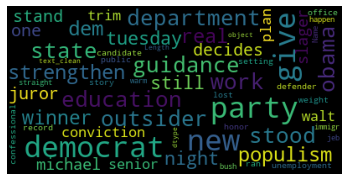

In [50]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [51]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


Text(5, 2, 'love')

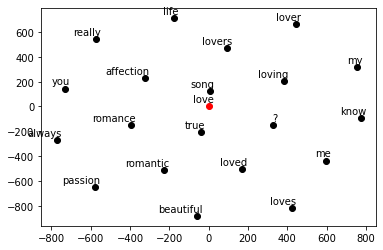

In [54]:
## find closest vectors
word = "love"
labels, X, x, y = [], [], [], []
for t in nlp.most_similar(word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])
## reduce dimensions
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])
## plot
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')
## add center
plt.scatter(x=0, y=0, c="red")
plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

Topic Modeling

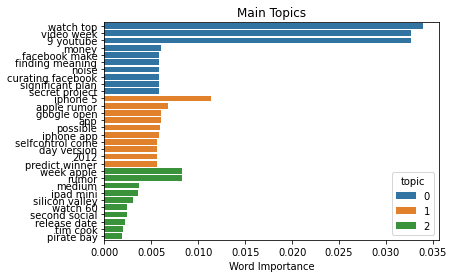

In [55]:
y = "TECH"
corpus = dtf[dtf["y"]==y]["text_clean"]

## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

Classification using Advance Techniques like


1.   Bag of words
2.   Word-Embeddings(TF-idf)

1.   Language Model
2.   BERT





In [57]:
!pip install lime

     |████████████████████████████████| 276kB 2.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=a6d94b1776259b86c9deb60ee136ae5566c4dd7b594a08b96c7136460672bc20
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [59]:
pip install transformers

     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 1.1MB 19.9MB/s 
     |████████████████████████████████| 3.0MB 24.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f7a623858f993da2ef01ce43e8c85eba520c21f515c7dbd0a05ac88def2c0eb5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [60]:
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

In [61]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

In [62]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [63]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [68]:
from sklearn import feature_selection

In [69]:
y = dtf_train["y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [70]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# ENTERTAINMENT:
  . selected features: 179
  . top features: movie,apple,star,taylor,swift,taylor swift,game throne,throne,trailer,facebook
 
# POLITICS:
  . selected features: 181
  . top features: trump,clinton,hillary,donald,gop,donald trump,hillary clinton,republican,obama,apple
 
# TECH:
  . selected features: 160
  . top features: apple,facebook,google,iphone,youtube,trump,tech,youtube video,top youtube,video week
 


In [71]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [72]:
classifier = naive_bayes.MultinomialNB()

In [73]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [75]:
from sklearn import metrics

Accuracy: 0.78
Auc: 0.93
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.68      0.84      0.75       581
     POLITICS       0.84      0.75      0.79       621
         TECH       0.86      0.76      0.80       604

     accuracy                           0.78      1806
    macro avg       0.79      0.78      0.78      1806
 weighted avg       0.79      0.78      0.78      1806



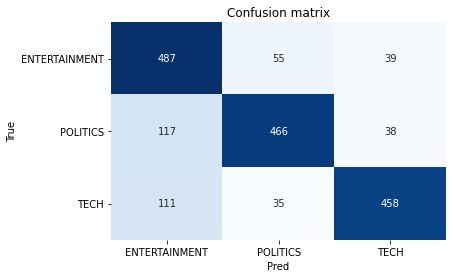

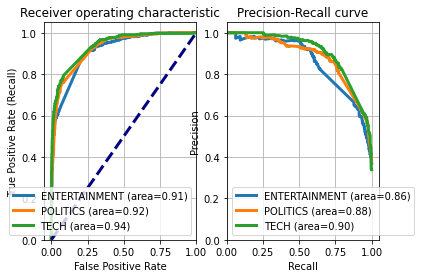

In [76]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [77]:
## select observation
i = 0
txt_instance = dtf_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: POLITICS --> Pred: POLITICS | Prob: 0.8


Word Embeddings

1.   Word2Vec



In [78]:
corpus = dtf_train["text_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [79]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1, iter=30)

In [80]:
word = "data"
nlp[word].shape

(300,)

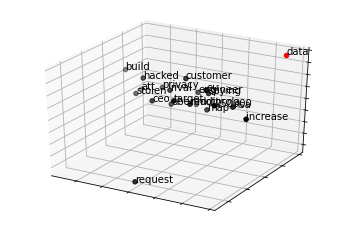

In [81]:
word = "data"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

BERT

Google’s BERT (Bidirectional Encoder Representations from Transformers, 2018) combines ELMO context embedding and several Transformers, plus it’s bidirectional (which was a big novelty for Transformers). The vector BERT assigns to a word is a function of the entire sentence, therefore, a word can have different vectors based on the contexts. Let’s try it using transformers:

In [82]:
txt = "bank river"
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
## return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]  
embedding = nlp(input_ids)
embedding[0][0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.3424595 ,  0.05200403, -0.25653863, ..., -0.24441804,
         0.05279785,  0.4490064 ],
       [-0.3836249 , -0.66715103, -0.35021198, ..., -0.10210519,
        -0.2162938 , -0.29299906],
       [-0.34996098, -0.08317025, -0.9876842 , ...,  0.06963336,
        -0.4945292 , -0.16088335],
       [ 0.7392345 ,  0.07391939, -0.45681   , ..., -0.02415817,
        -0.7649663 , -0.28110647]], dtype=float32)>

In order to complete a text classification task, we can use BERT in 3 different ways:

train it all from scratches and use it as classifier.
Extract the word embeddings and use them in an embedding layer (like I did with Word2Vec).
Fine-tuning the pre-trained model (transfer learning).

In [83]:
## distil-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [101]:
corpus = dtf_train["text"]
maxlen = 50

## add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ["[CLS] "+
             " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
             str(txt).lower().strip()))[:maxqnans])+
             " [SEP] " for txt in corpus]

## generate masks
masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(
           txt.split(" "))) for txt in corpus_tokenized]
    
## padding
txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]
    
## generate idx
idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]
    
## generate segments
segments = [] 
for seq in txt2seq:
    temp, i = [], 0
    for token in seq.split(" "):
        temp.append(i)
        if token == "[SEP]":
             i += 1
    segments.append(temp)
## feature matrix
X_train = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

X_test = [np.asarray(idx, dtype='int32'), 
           np.asarray(masks, dtype='int32'), 
           np.asarray(segments, dtype='int32')]

In [88]:
i = 0
print("txt: ", dtf_train["text"].iloc[10])
print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
print("idx: ", X_train[0][i])
print("mask: ", X_train[1][i])
print("segment: ", X_train[2][i])

txt:  These 6 Creepy, Abandoned Islands Are Definitely Not Suitable for Your Next Vacation
tokenized: ['[CLS]', '[CLS]', 'celebrity', 'collector', 'john', 'force', '[SEP]', '[UNK]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[SEP]']
idx:  [  101   101  8958 10018  2198  2486   102   100     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0   102]
mask:  [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

In [90]:
## inputs
idx = layers.Input((50), dtype="int32", name="input_idx")
masks = layers.Input((50), dtype="int32", name="input_masks")
## pre-trained bert with config
config = transformers.DistilBertConfig(dropout=0.2, 
           attention_dropout=0.2)
config.output_hidden_states = False
nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0]
## fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation="relu")(x)
y_out = layers.Dense(len(np.unique(y_train)), 
                     activation='softmax')(x)
## compile
model = models.Model([idx, masks], y_out)
for layer in model.layers[:3]:
    layer.trainable = False
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB ((None, 50, 768),)   66362880    input_idx[0][0]                  
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_distil_bert_model[0

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=64,epochs=1, shuffle=True, verbose=1,validation_split=0.3)
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

Accuracy: 0.64
Auc: 0.88
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.56      0.97      0.71      6432
     POLITICS       0.94      0.40      0.56      7184
         TECH       0.80      0.30      0.44      1073

     accuracy                           0.64     14689
    macro avg       0.76      0.56      0.57     14689
 weighted avg       0.76      0.64      0.62     14689


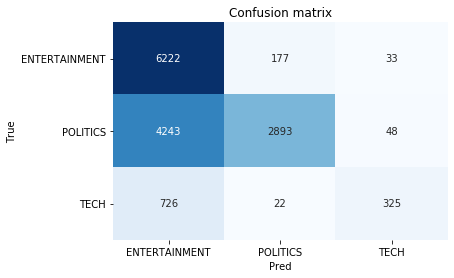



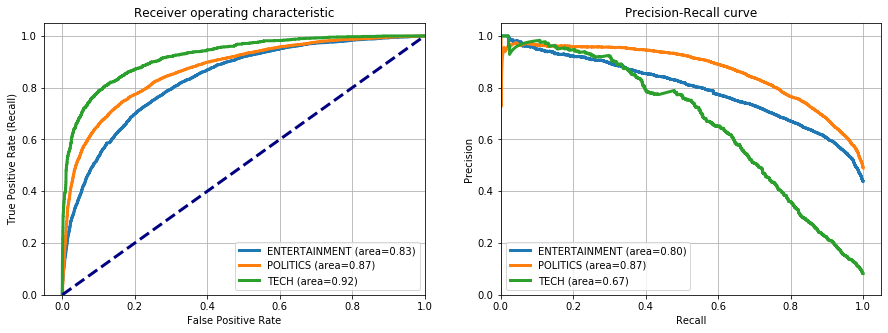